In [2]:
import io

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import scipy
import scipy.stats as st

print(f"Running on PyMC3 v{pm.__version__}")

Running on PyMC3 v3.11.1


In [3]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# Model building and expansion for golf putting

**This uses and closely follows [the case study from Andrew Gelman](https://mc-stan.org/users/documentation/case-studies/golf.html), written in Stan. There are some new visualizations and I steered away from using improper priors, but much credit to him and to the Stan group for the wonderful case study and software.**

We use a data set from "Statistics: A Bayesian Perspective", by Don Berry (1995). The dataset describes the outcome of professional golfers putting from a number of distances, and is small enough that we can just print and load it inline, instead of doing any special `csv` reading. 

In [4]:
# golf putting data from berry (1996)
golf_data = """distance tries successes
2 1443 1346
3 694 577
4 455 337
5 353 208
6 272 149
7 256 136
8 240 111
9 217 69
10 200 67
11 237 75
12 202 52
13 192 46
14 174 54
15 167 28
16 201 27
17 195 31
18 191 33
19 147 20
20 152 24"""


golf_data = pd.read_csv(io.StringIO(golf_data), sep=" ")

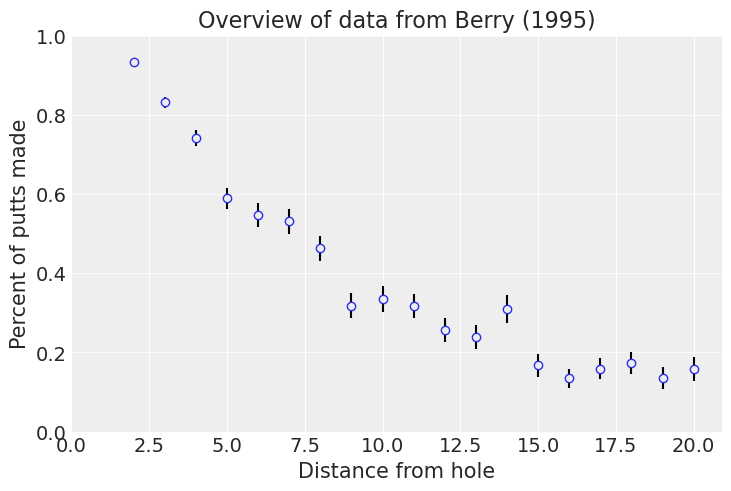

In [5]:
def plot_golf_data(golf_data, ax=None):
    """Utility function to standardize a pretty plotting of the golf data."""
    if ax is None:
        _, ax = plt.subplots()
    bg_color = ax.get_facecolor()
    rv = st.beta(golf_data.successes, golf_data.tries - golf_data.successes)
    ax.vlines(golf_data.distance, *rv.interval(0.68), label=None)
    ax.plot(
        golf_data.distance, golf_data.successes / golf_data.tries, "o", mfc=bg_color, label=None
    )

    ax.set_xlabel("Distance from hole")
    ax.set_ylabel("Percent of putts made")
    ax.set_ylim(bottom=0, top=1)

    ax.set_xlim(left=0)
    ax.grid(True, axis="y", alpha=0.7)
    return ax


ax = plot_golf_data(golf_data)
ax.set_title("Overview of data from Berry (1995)");

After plotting, we see that generally golfers are less accurate from further away. Note that this data is pre-aggregated: we may be able to do more interesting work with granular putt-by-putt data. This data set appears to have been binned to the nearest foot. 

We might think about doing prediction with this data: fitting a curve to this data would allow us to make reasonable guesses at intermediate distances, as well as perhaps to extrapolate to longer distances. 

## Logit model

First we will fit a traditional logit-binomial model. We model the number of successes directly, with

$$
a, b \sim \mathcal{N}(0, 1) \\
p(\text{success}) = \operatorname{logit}^{-1}(a \cdot \text{distance} + b) \\ 
\text{num. successes} \sim \operatorname{Binomial}(\text{tries}, p(\text{success}))
$$

Here is how to write that model in PyMC3. We wrap our models in functions to avoid polluting the namespace, and to let us swap out the data later, when we will work with a newer data set.

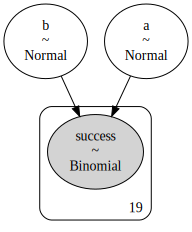

In [6]:
def logit_model(golf_data):
    with pm.Model() as logit_binomial:
        a = pm.Normal("a")
        b = pm.Normal("b")

        success = pm.Binomial(
            "success",
            n=golf_data.tries,
            p=pm.math.invlogit(a * golf_data.distance + b),
            observed=golf_data.successes,
        )
    return logit_binomial


pm.model_to_graphviz(logit_model(golf_data))

We have some intuition that $a$ should be negative, and also that $b$ should be positive (since when $\text{distance} = 0$, we expect to make nearly 100% of putts). We are not putting that into the model, though. We are using this as a baseline, and we may as well wait and see if we need to add stronger priors.

In [7]:
with logit_model(golf_data):
    logit_trace = pm.sample(1000, tune=1000, return_inferencedata=True)


az.summary(logit_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,-0.255,0.007,-0.266,-0.242,0.000,0.000,452.0,691.0,1.0
b,2.223,0.059,2.117,2.332,0.003,0.002,451.0,658.0,1.0


We see $a$ and $b$ have the signs we expected. There were no bad warnings emitted from the sampler. Looking at the summary, the number of effective samples is reasonable, and the rhat is close to 1. This is a small model, so we are not being too careful about inspecting the fit.

We plot 50 posterior draws of $p(\text{success})$ along with the expected value. Also, we draw 500 points from the posterior predictive to plot:

/opt/conda/lib/python3.7/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


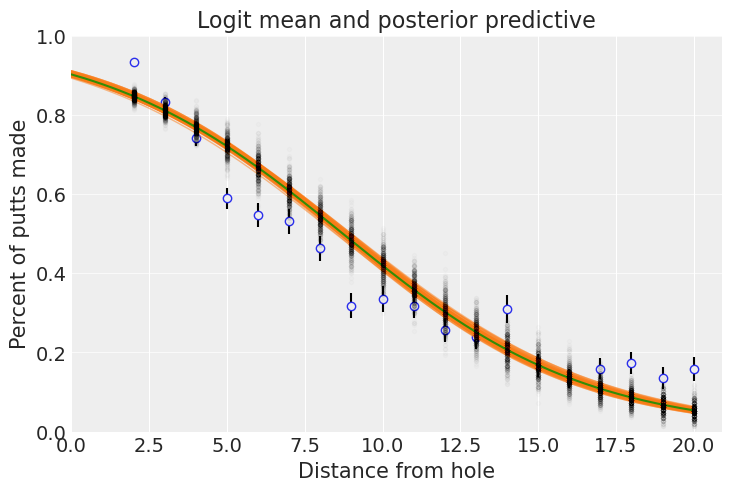

In [8]:
# Draw posterior predictive samples
with logit_model(golf_data):
    # hard to plot more than 500 sensibly
    logit_ppc = pm.sample_posterior_predictive(logit_trace, samples=500)

logit_ppc_success = logit_ppc["success"].T / golf_data.tries.values.reshape(-1, 1)

# Plotting
ax = plot_golf_data(golf_data)
t = np.linspace(0, golf_data.distance.max(), 200)

logit_trace_post_a = logit_trace.posterior["a"].data.flatten()
logit_trace_post_b = logit_trace.posterior["b"].data.flatten()

for idx in np.random.randint(0, len(logit_trace_post_a), 50):
    ax.plot(
        t,
        scipy.special.expit(logit_trace_post_a[idx] * t + logit_trace_post_b[idx]),
        lw=1,
        color="C1",
        alpha=0.5,
    )
ax.plot(
    t,
    scipy.special.expit(
        logit_trace_post_a.reshape(-1, 1) * t + logit_trace_post_b.reshape(-1, 1)
    ).mean(axis=0),
    color="C2",
)

ax.plot(golf_data.distance, logit_ppc_success, "k.", alpha=0.01)
ax.set_title("Logit mean and posterior predictive");

The fit is ok, but not great! It is a good start for a baseline, and lets us answer curve-fitting type questions. We may not trust much extrapolation beyond the end of the data, especially given how the curve does not fit the last four values very well. For example, putts from 50 feet are expected to be made with probability:

In [9]:
print(f"{100 * scipy.special.expit(logit_trace_post_a * 50 + logit_trace_post_b).mean():.5f}%")

0.00281%


### Aside: Calculating expectations with traces

An interesting thing to note about calculating the posterior expectation -- a strength of Bayesian models is that you can get strong correlations between parameters, which often show up particularly in regression models:

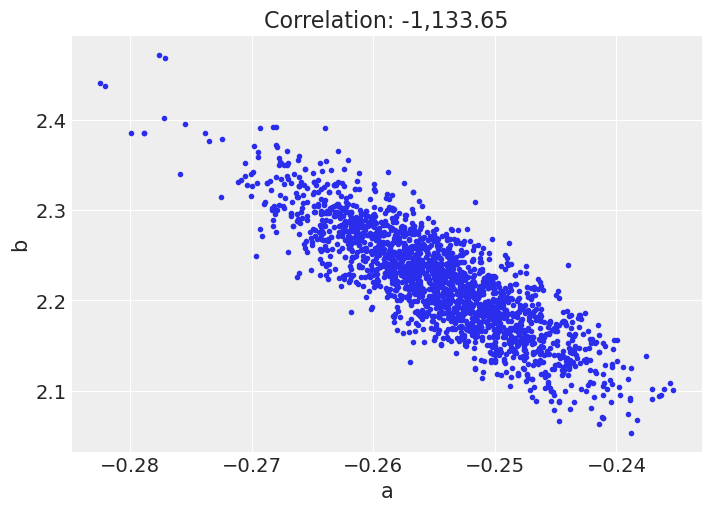

In [10]:
ax = az.plot_pair(logit_trace, figsize=(7, 5))

(corr,) = np.correlate(logit_trace_post_a, logit_trace_post_b)
ax.set_title(f"Correlation: {corr:,.2f}");

The lesson from this is that

$$
\mathbb{E}[f(\theta)] \ne f(\mathbb{E}[\theta]).
$$

this appeared here in using 

```python
# Right!
scipy.special.expit(logit_trace_post_a * 50 + logit_trace_post_b).mean()
```
rather than

```python
# Wrong!
scipy.special.expit(logit_trace_post_a.mean() * 50 + logit_trace_post_b.mean())
```

to calculate our expectation at 50 feet.

## Geometry-based model

As a second pass at modelling this data, both to improve fit and to increase confidence in extrapolation, we think about the geometry of the situation. We suppose professional golfers can hit the ball in a certain direction, with some small(?) error. Specifically, the angle the ball actually travels is normally distributed around 0, with some variance that we will try to learn.

Then the ball goes in whenever the error in angle is small enough that the ball still hits the cup. This is intuitively nice! A longer putt will admit a smaller error in angle, and so a lower success rate than for shorter putts.

I am skipping a derivation of the probability of making a putt given the accuracy variance and distance to the hole, but it is a fun exercise in geometry, and turns out to be

$$
p(\text{success} | \sigma_{\text{angle}}, \text{distance}) = 2 \Phi\left( \frac{ \arcsin \left((R - r) / \text{distance}\right)}{\sigma_{\text{angle}}}\right),
$$

where $\Phi$ is the normal cumulative density function, $R$ is the radius of the cup (turns out 2.125 inches), and $r$ is the radius of the golf ball (around 0.84 inches).

To get a feeling for this model, let's look at a few manually plotted values for $\sigma_{\text{angle}}$.

<ipython-input-10-3e075d111d08>:6: RuntimeWarning: divide by zero encountered in true_divide
  return 2 * st.norm(0, variance_of_shot).cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t)) - 1
<ipython-input-10-3e075d111d08>:6: RuntimeWarning: invalid value encountered in arcsin
  return 2 * st.norm(0, variance_of_shot).cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t)) - 1
<ipython-input-10-3e075d111d08>:6: RuntimeWarning: divide by zero encountered in true_divide
  return 2 * st.norm(0, variance_of_shot).cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t)) - 1
<ipython-input-10-3e075d111d08>:6: RuntimeWarning: invalid value encountered in arcsin
  return 2 * st.norm(0, variance_of_shot).cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t)) - 1
<ipython-input-10-3e075d111d08>:6: RuntimeWarning: divide by zero encountered in true_divide
  return 2 * st.norm(0, variance_of_shot).cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t)) - 1
<ipython-input-10-3e075d111d08>:6: RuntimeWarning: invalid value encountered in ar

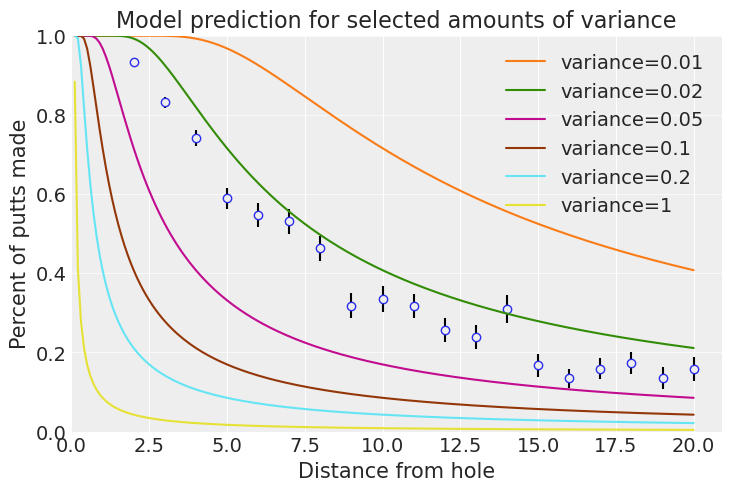

In [11]:
BALL_RADIUS = (1.68 / 2) / 12
CUP_RADIUS = (4.25 / 2) / 12


def forward_angle_model(variance_of_shot, t):
    return 2 * st.norm(0, variance_of_shot).cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t)) - 1


ax = plot_golf_data(golf_data)

t = np.linspace(CUP_RADIUS - BALL_RADIUS, golf_data.distance.max(), 200)

for variance_of_shot in (0.01, 0.02, 0.05, 0.1, 0.2, 1):
    ax.plot(t, forward_angle_model(variance_of_shot, t), label=f"variance={variance_of_shot}")
ax.set_title("Model prediction for selected amounts of variance")
ax.legend();

This looks like a promising approach! A variance of 0.02 radians looks like it will be close to the right answer. The model also predicted that putts from 0 feet all go in, which is a nice side effect. We might think about whether a golfer misses putts symmetrically. It is plausible that a right handed putter and a left handed putter might have a different bias to their shots.
### Fitting the model

PyMC3 has $\Phi$ implemented, but it is pretty hidden (`pm.distributions.dist_math.normal_lcdf`), and it is worthwhile to implement it ourselves anyways, using an identity with the [error function](https://en.wikipedia.org/wiki/Error_function). 

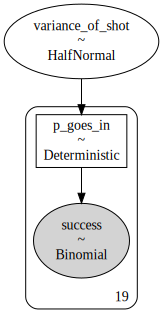

In [12]:
import theano.tensor as tt


def phi(x):
    """Calculates the standard normal cumulative distribution function."""
    return 0.5 + 0.5 * tt.erf(x / tt.sqrt(2.0))


def angle_model(golf_data):
    with pm.Model() as angle_model:
        variance_of_shot = pm.HalfNormal("variance_of_shot")
        p_goes_in = pm.Deterministic(
            "p_goes_in",
            2 * phi(tt.arcsin((CUP_RADIUS - BALL_RADIUS) / golf_data.distance) / variance_of_shot)
            - 1,
        )
        success = pm.Binomial(
            "success", n=golf_data.tries, p=p_goes_in, observed=golf_data.successes
        )
    return angle_model


pm.model_to_graphviz(angle_model(golf_data))

### Prior Predictive Checks

We often wish to sample from the prior, especially if we have some idea of what the observations would look like, but not a lot of intuition for the prior parameters. We have an angle-based model here, but it might not be intuitive if the *variance* of the angle is given, how that effects the accuracy of a shot. Let's check!

Sometimes a custom visualization or dashboard is useful for a prior predictive check. Here, we plot our prior distribution of putts from 20 feet away.

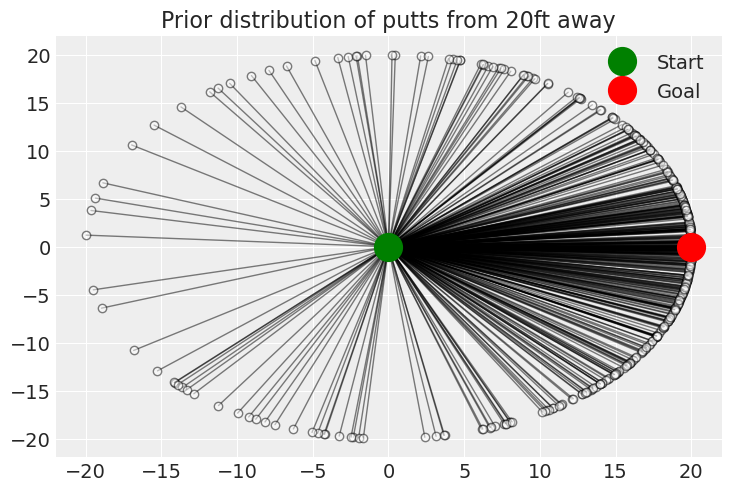

In [13]:
with angle_model(golf_data):
    angle_prior = pm.sample_prior_predictive(500)

angle_of_shot = np.random.normal(0, angle_prior["variance_of_shot"])  # radians
distance = 20  # feet

end_positions = np.array([distance * np.cos(angle_of_shot), distance * np.sin(angle_of_shot)])

fig, ax = plt.subplots()
for endx, endy in end_positions.T:
    ax.plot([0, endx], [0, endy], "k-o", lw=1, mfc="w", alpha=0.5)
ax.plot(0, 0, "go", label="Start", mfc="g", ms=20)
ax.plot(distance, 0, "ro", label="Goal", mfc="r", ms=20)

ax.set_title(f"Prior distribution of putts from {distance}ft away")

ax.legend();

This is a little funny! Most obviously, it should probably be not this common to putt the ball *backwards*. This also leads us to worry that we are using a normal distribution to model an angle. The [von Mises](https://en.wikipedia.org/wiki/Von_Mises_distribution) distribution may be appropriate here. Also, the golfer needs to stand somewhere, so perhaps adding some bounds to the von Mises would be appropriate. We will find that this model learns from the data quite well, though, and these additions are not necessary.

In [14]:
with angle_model(golf_data):
    angle_trace = pm.sample(1000, tune=1000, return_inferencedata=True)

<ipython-input-10-3e075d111d08>:6: RuntimeWarning: divide by zero encountered in true_divide
  return 2 * st.norm(0, variance_of_shot).cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t)) - 1
<ipython-input-10-3e075d111d08>:6: RuntimeWarning: invalid value encountered in arcsin
  return 2 * st.norm(0, variance_of_shot).cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t)) - 1
<ipython-input-10-3e075d111d08>:6: RuntimeWarning: divide by zero encountered in true_divide
  return 2 * st.norm(0, variance_of_shot).cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t)) - 1
<ipython-input-10-3e075d111d08>:6: RuntimeWarning: invalid value encountered in arcsin
  return 2 * st.norm(0, variance_of_shot).cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t)) - 1
<ipython-input-10-3e075d111d08>:6: RuntimeWarning: divide by zero encountered in true_divide
  return 2 * st.norm(0, variance_of_shot).cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t)) - 1
<ipython-input-10-3e075d111d08>:6: RuntimeWarning: invalid value encountered in ar

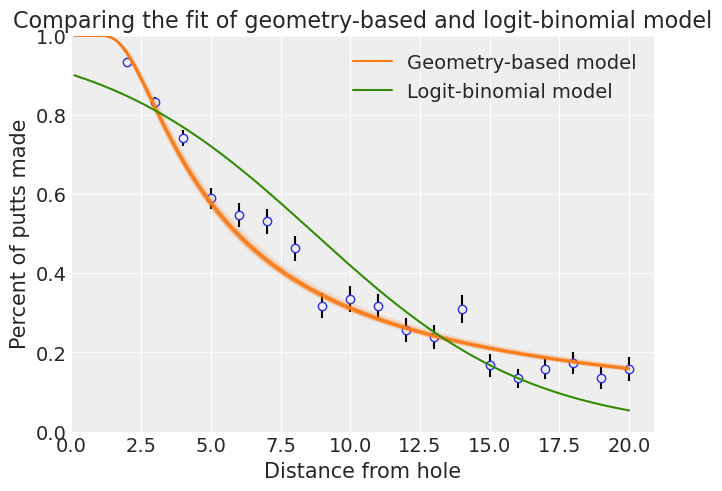

In [15]:
ax = plot_golf_data(golf_data)

t = np.linspace(CUP_RADIUS - BALL_RADIUS, golf_data.distance.max(), 200)

angle_trace_post_variance_of_shot = angle_trace.posterior["variance_of_shot"].data.flatten()
for idx in np.random.randint(0, len(angle_trace_post_variance_of_shot), 50):
    ax.plot(
        t,
        forward_angle_model(angle_trace_post_variance_of_shot[idx], t),
        lw=1,
        color="C1",
        alpha=0.1,
    )
ax.plot(
    t,
    forward_angle_model(angle_trace_post_variance_of_shot.mean(), t),
    label="Geometry-based model",
)

ax.plot(
    t,
    scipy.special.expit(logit_trace_post_a.mean() * t + logit_trace_post_b.mean()),
    label="Logit-binomial model",
)
ax.set_title("Comparing the fit of geometry-based and logit-binomial model")
ax.legend();

This new model appears to fit much better, and by modelling the geometry of the situation, we may have a bit more confidence in extrapolating the data. This model suggests that a 50 foot putt has much higher chance of going in:

In [16]:
print(
    f"{100 * forward_angle_model(angle_trace_post_variance_of_shot, 50).mean():.2f}% vs {100 * scipy.special.expit(logit_trace_post_a * 50 + logit_trace_post_b).mean():.5f}%"
)

6.39% vs 0.00281%


We can also recreate our prior predictive plot, giving us some confidence that the prior was not leading to unreasonable situations in the posterior distribution: the variance in angle is quite small!

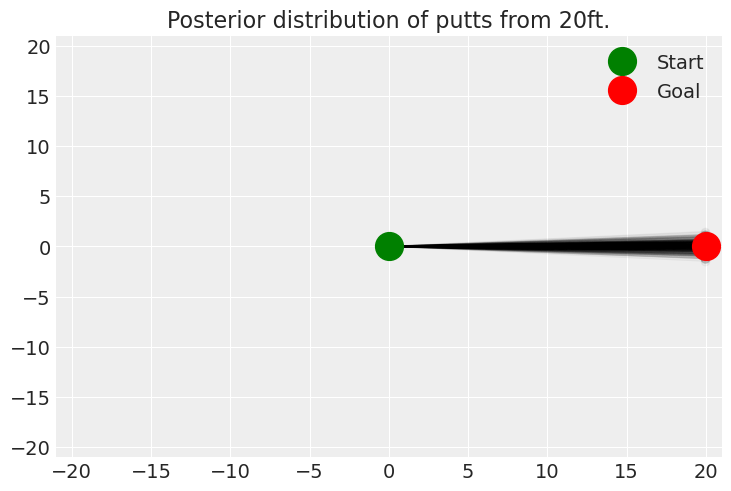

In [17]:
angle_of_shot = np.random.normal(
    0, np.random.choice(angle_trace_post_variance_of_shot, 500)
)  # radians
distance = 20  # feet

end_positions = np.array([distance * np.cos(angle_of_shot), distance * np.sin(angle_of_shot)])

fig, ax = plt.subplots()
for endx, endy in end_positions.T:
    ax.plot([0, endx], [0, endy], "k-o", lw=1, mfc="w", alpha=0.05)
ax.plot(0, 0, "go", label="Start", mfc="g", ms=20)
ax.plot(distance, 0, "ro", label="Goal", mfc="r", ms=20)

ax.set_xlim(-21, 21)
ax.set_ylim(-21, 21)
ax.set_title(f"Posterior distribution of putts from {distance}ft.")
ax.legend();

## New Data!

Mark Broadie used new summary data on putting to fit a new model. We will use this new data to refine our model:

In [18]:
#  golf putting data from Broadie (2018)
new_golf_data = """distance tries successes
0.28 45198 45183
0.97 183020 182899
1.93 169503 168594
2.92 113094 108953
3.93 73855 64740
4.94 53659 41106
5.94 42991 28205
6.95 37050 21334
7.95 33275 16615
8.95 30836 13503
9.95 28637 11060
10.95 26239 9032
11.95 24636 7687
12.95 22876 6432
14.43 41267 9813
16.43 35712 7196
18.44 31573 5290
20.44 28280 4086
21.95 13238 1642
24.39 46570 4767
28.40 38422 2980
32.39 31641 1996
36.39 25604 1327
40.37 20366 834
44.38 15977 559
48.37 11770 311
52.36 8708 231
57.25 8878 204
63.23 5492 103
69.18 3087 35
75.19 1742 24"""

new_golf_data = pd.read_csv(io.StringIO(new_golf_data), sep=" ")

<ipython-input-10-3e075d111d08>:6: RuntimeWarning: divide by zero encountered in true_divide
  return 2 * st.norm(0, variance_of_shot).cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t)) - 1
<ipython-input-10-3e075d111d08>:6: RuntimeWarning: invalid value encountered in arcsin
  return 2 * st.norm(0, variance_of_shot).cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t)) - 1


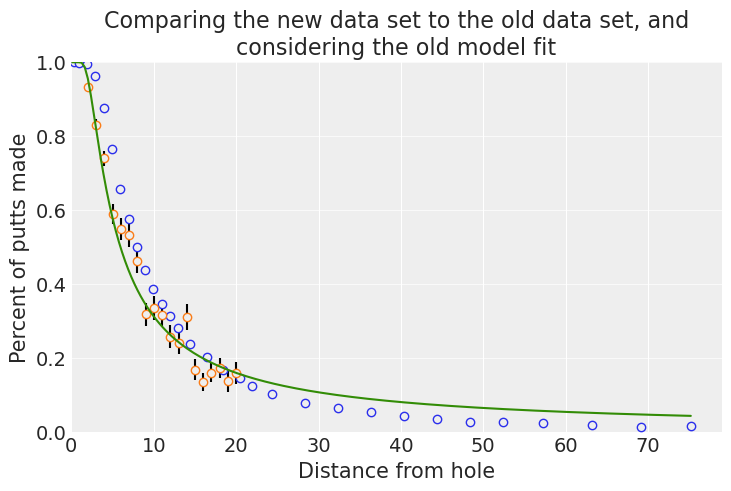

In [19]:
ax = plot_golf_data(new_golf_data)
plot_golf_data(golf_data, ax=ax)
t = np.linspace(CUP_RADIUS - BALL_RADIUS, new_golf_data.distance.max(), 200)

ax.plot(t, forward_angle_model(angle_trace_post_variance_of_shot.mean(), t))
ax.set_title("Comparing the new data set to the old data set, and\nconsidering the old model fit");

This new data set represents ~200 times the number of putt attempts as the old data, and includes putts up to 75ft, compared to 20ft for the old data set. It also seems that the new data represents a different population from the old data: while the two have different bins, the new data suggests higher success for most data. This may be from a different method of collecting the data, or golfers improving in the intervening years.

## Fitting the model on the new data

Since we think these may be two different populations, the easiest solution would be to refit our model. This goes worse than earlier: there are divergences, and it takes much longer to run. This may indicate a problem with the model: Andrew Gelman calls this the "folk theorem of statistical computing".

In [20]:
with angle_model(new_golf_data):
    new_angle_trace = pm.sample(1000, tune=1000, return_inferencedata=True)

<ipython-input-10-3e075d111d08>:6: RuntimeWarning: divide by zero encountered in true_divide
  return 2 * st.norm(0, variance_of_shot).cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t)) - 1
<ipython-input-10-3e075d111d08>:6: RuntimeWarning: invalid value encountered in arcsin
  return 2 * st.norm(0, variance_of_shot).cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t)) - 1
<ipython-input-10-3e075d111d08>:6: RuntimeWarning: divide by zero encountered in true_divide
  return 2 * st.norm(0, variance_of_shot).cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t)) - 1
<ipython-input-10-3e075d111d08>:6: RuntimeWarning: invalid value encountered in arcsin
  return 2 * st.norm(0, variance_of_shot).cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t)) - 1


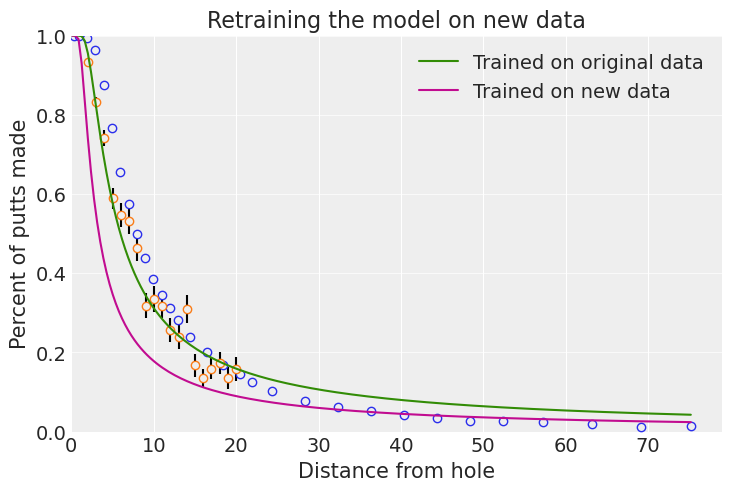

In [21]:
ax = plot_golf_data(new_golf_data)
plot_golf_data(golf_data, ax=ax)
t = np.linspace(CUP_RADIUS - BALL_RADIUS, new_golf_data.distance.max(), 200)

new_angle_trace_post_variance_of_shot = new_angle_trace.posterior["variance_of_shot"].data.flatten()

ax.plot(
    t,
    forward_angle_model(angle_trace_post_variance_of_shot.mean(), t),
    label="Trained on original data",
)
ax.plot(
    t,
    forward_angle_model(new_angle_trace_post_variance_of_shot.mean(), t),
    label="Trained on new data",
)
ax.set_title("Retraining the model on new data")
ax.legend();

## A model incorporating distance to hole

We might assume that, in addition to putting in the right direction, a golfer may need to hit the ball the right distance. Specifically, we assume:

1. If a put goes short *or* more than 3 feet past the hole, it will not go in.
2. Golfers aim for 1 foot past the hole
3. The distance the ball goes, $u$, is distributed according to
$$
u \sim \mathcal{N}\left(1 + \text{distance}, \sigma_{\text{distance}} (1 + \text{distance})\right),
$$
where we will learn $\sigma_{\text{distance}}$.

Again, this is a geometry and algebra problem to work the probability that the ball goes in from any given distance: 
$$
P(\text{good distance}) = P(\text{distance} < u < \text{distance} + 3)
$$

it uses `phi`, the cumulative normal density function we implemented earlier.

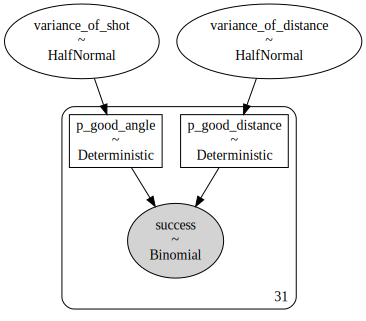

In [22]:
OVERSHOT = 1.0
DISTANCE_TOLERANCE = 3.0


def distance_angle_model(golf_data):
    distances = golf_data.distance.values
    with pm.Model() as distance_angle_model:
        variance_of_shot = pm.HalfNormal("variance_of_shot")
        variance_of_distance = pm.HalfNormal("variance_of_distance")
        p_good_angle = pm.Deterministic(
            "p_good_angle",
            2 * phi(tt.arcsin((CUP_RADIUS - BALL_RADIUS) / distances) / variance_of_shot) - 1,
        )
        p_good_distance = pm.Deterministic(
            "p_good_distance",
            phi((DISTANCE_TOLERANCE - OVERSHOT) / ((distances + OVERSHOT) * variance_of_distance))
            - phi(-OVERSHOT / ((distances + OVERSHOT) * variance_of_distance)),
        )

        success = pm.Binomial(
            "success",
            n=golf_data.tries,
            p=p_good_angle * p_good_distance,
            observed=golf_data.successes,
        )
    return distance_angle_model


pm.model_to_graphviz(distance_angle_model(new_golf_data))

This model still has only 2 dimensions to fit. We might think about checking on `OVERSHOT` and `DISTANCE_TOLERANCE`. Checking the first might involve a call to a local golf course, and the second might require a trip to a green and some time experimenting. We might also think about adding some explicit correlations: it is plausible that less control over angle would correspond to less control over distance, or that longer putts lead to more variance in the angle.

## Fitting the distance angle model

In [23]:
with distance_angle_model(new_golf_data):
    distance_angle_trace = pm.sample(1000, tune=1000, return_inferencedata=True)

<ipython-input-10-3e075d111d08>:6: RuntimeWarning: divide by zero encountered in true_divide
  return 2 * st.norm(0, variance_of_shot).cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t)) - 1
<ipython-input-10-3e075d111d08>:6: RuntimeWarning: invalid value encountered in arcsin
  return 2 * st.norm(0, variance_of_shot).cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t)) - 1
<ipython-input-23-39561f6bc93e>:3: RuntimeWarning: divide by zero encountered in true_divide
  angle_prob = 2 * rv.cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t) / variance_of_shot) - 1
<ipython-input-23-39561f6bc93e>:3: RuntimeWarning: invalid value encountered in arcsin
  angle_prob = 2 * rv.cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t) / variance_of_shot) - 1


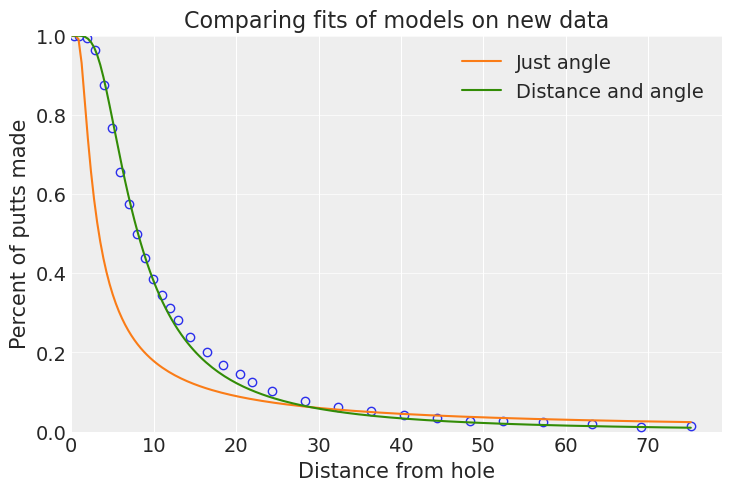

In [24]:
def forward_distance_angle_model(variance_of_shot, variance_of_distance, t):
    rv = st.norm(0, 1)
    angle_prob = 2 * rv.cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t) / variance_of_shot) - 1

    distance_prob_one = rv.cdf(
        (DISTANCE_TOLERANCE - OVERSHOT) / ((t + OVERSHOT) * variance_of_distance)
    )
    distance_prob_two = rv.cdf(-OVERSHOT / ((t + OVERSHOT) * variance_of_distance))
    distance_prob = distance_prob_one - distance_prob_two

    return angle_prob * distance_prob


ax = plot_golf_data(new_golf_data)
t = np.linspace(CUP_RADIUS - BALL_RADIUS, new_golf_data.distance.max(), 200)

distance_angle_trace_post_variance_of_shot = distance_angle_trace.posterior[
    "variance_of_shot"
].data.flatten()
distance_angle_trace_post_variance_of_distance = distance_angle_trace.posterior[
    "variance_of_distance"
].data.flatten()

ax.plot(t, forward_angle_model(new_angle_trace_post_variance_of_shot.mean(), t), label="Just angle")
ax.plot(
    t,
    forward_distance_angle_model(
        distance_angle_trace_post_variance_of_shot.mean(),
        distance_angle_trace_post_variance_of_distance.mean(),
        t,
    ),
    label="Distance and angle",
)

ax.set_title("Comparing fits of models on new data")
ax.legend();

This new model looks better, and fit much more quickly with fewer sampling problems compared to the old model.There is some mismatch between 10 and 40 feet, but it seems generally good. We can come to this same conclusion by taking posterior predictive samples, and looking at the residuals. Here, we see that the fit is being driven by the first 4 bins, which contain ~40% of the data.

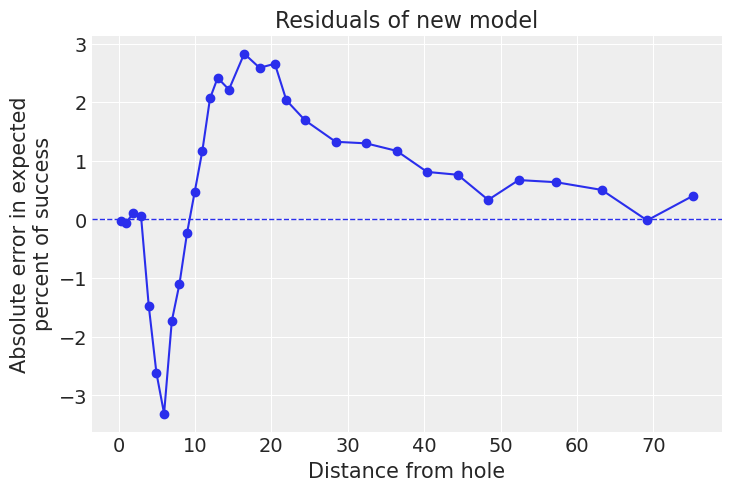

In [25]:
with distance_angle_model(new_golf_data):
    ppc = pm.sample_posterior_predictive(distance_angle_trace)

residuals = 100 * (new_golf_data.successes - ppc["success"].mean(axis=0)) / new_golf_data.tries

fig, ax = plt.subplots()

ax.plot(new_golf_data.distance, residuals, "o-")
ax.axhline(y=0, linestyle="dashed", linewidth=1)
ax.set_xlabel("Distance from hole")
ax.set_ylabel("Absolute error in expected\npercent of success")

ax.set_title("Residuals of new model");

## A new model

It is reasonable to stop at this point, but if we want to improve the fit everywhere, we may want to choose a different likelihood from the `Binomial`, which cares deeply about those points with many observations. One thing we could do is add some independent extra error to each data point. We could do this in a few ways: 
1. The `Binomial` distribution in usually parametrized by $n$, the number of observations, and $p$, the probability of an individual success. We could instead parametrize it by mean ($np$) and variance ($np(1-p)$), and add error independent of $n$ to the likelihood.
2. Use a `BetaBinomial` distribution, though the error there would still be (roughly) proportional to the number observations
3. Approximate the Binomial with a Normal distribution of the probability of success. This is actually equivalent to the first approach, but does not require a custom distribution. Note that we will use $p$ as the mean, and $p(1-p) / n$ as the variance. Once we add some dispersion $\epsilon$, the variance becomes $p(1-p)/n + \epsilon$.

We follow approach 3, as in the Stan case study, and leave 1 as an exercise.

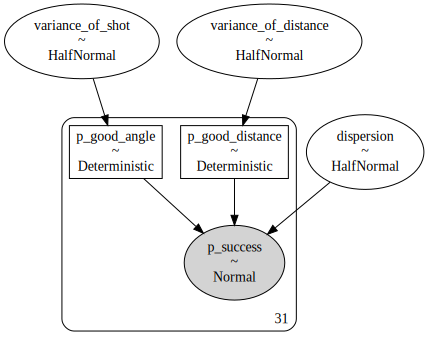

In [26]:
def disp_distance_angle_model(golf_data):
    distances = golf_data.distance.values
    with pm.Model() as distance_angle_model:
        variance_of_shot = pm.HalfNormal("variance_of_shot")
        variance_of_distance = pm.HalfNormal("variance_of_distance")
        dispersion = pm.HalfNormal("dispersion")

        p_good_angle = pm.Deterministic(
            "p_good_angle",
            2 * phi(tt.arcsin((CUP_RADIUS - BALL_RADIUS) / distances) / variance_of_shot) - 1,
        )
        p_good_distance = pm.Deterministic(
            "p_good_distance",
            phi((DISTANCE_TOLERANCE - OVERSHOT) / ((distances + OVERSHOT) * variance_of_distance))
            - phi(-OVERSHOT / ((distances + OVERSHOT) * variance_of_distance)),
        )

        p = p_good_angle * p_good_distance
        p_success = pm.Normal(
            "p_success",
            mu=p,
            sigma=tt.sqrt(((p * (1 - p)) / golf_data.tries) + dispersion ** 2),
            observed=golf_data.successes / golf_data.tries,
        )
    return distance_angle_model


pm.model_to_graphviz(disp_distance_angle_model(new_golf_data))

In [27]:
with disp_distance_angle_model(new_golf_data):
    disp_distance_angle_trace = pm.sample(1000, tune=1000, return_inferencedata=True)
    disp_ppc = pm.sample_posterior_predictive(disp_distance_angle_trace)

<ipython-input-23-39561f6bc93e>:3: RuntimeWarning: divide by zero encountered in true_divide
  angle_prob = 2 * rv.cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t) / variance_of_shot) - 1
<ipython-input-23-39561f6bc93e>:3: RuntimeWarning: invalid value encountered in arcsin
  angle_prob = 2 * rv.cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t) / variance_of_shot) - 1
<ipython-input-23-39561f6bc93e>:3: RuntimeWarning: divide by zero encountered in true_divide
  angle_prob = 2 * rv.cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t) / variance_of_shot) - 1
<ipython-input-23-39561f6bc93e>:3: RuntimeWarning: invalid value encountered in arcsin
  angle_prob = 2 * rv.cdf(np.arcsin((CUP_RADIUS - BALL_RADIUS) / t) / variance_of_shot) - 1


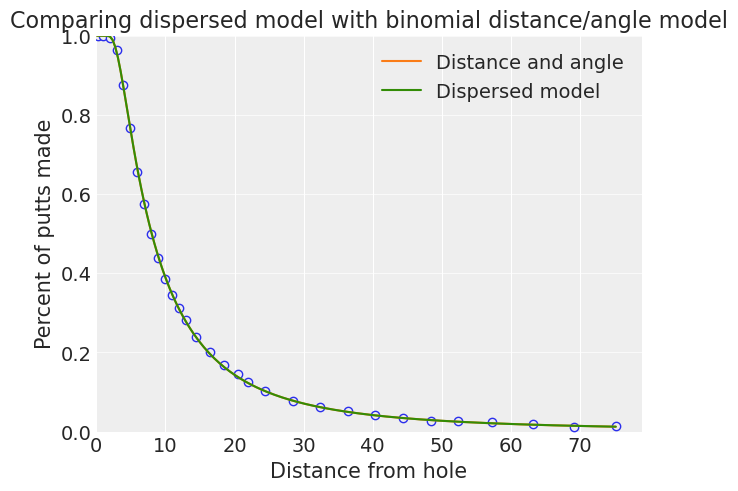

In [28]:
ax = plot_golf_data(new_golf_data, ax=None)
t = np.linspace(CUP_RADIUS - BALL_RADIUS, new_golf_data.distance.max(), 200)

disp_distance_angle_trace_post_variance_of_shot = disp_distance_angle_trace.posterior[
    "variance_of_shot"
].data.flatten()
disp_distance_angle_trace_post_variance_of_distance = disp_distance_angle_trace.posterior[
    "variance_of_distance"
].data.flatten()

ax.plot(
    t,
    forward_distance_angle_model(
        disp_distance_angle_trace_post_variance_of_shot.mean(),
        disp_distance_angle_trace_post_variance_of_distance.mean(),
        t,
    ),
    label="Distance and angle",
)
ax.plot(
    t,
    forward_distance_angle_model(
        disp_distance_angle_trace_post_variance_of_shot.mean(),
        disp_distance_angle_trace_post_variance_of_distance.mean(),
        t,
    ),
    label="Dispersed model",
)
ax.set_title("Comparing dispersed model with binomial distance/angle model")
ax.legend();

This new model does better between 10 and 30 feet, as we can also see using the residuals plot - note that this model does marginally worse for very short putts:

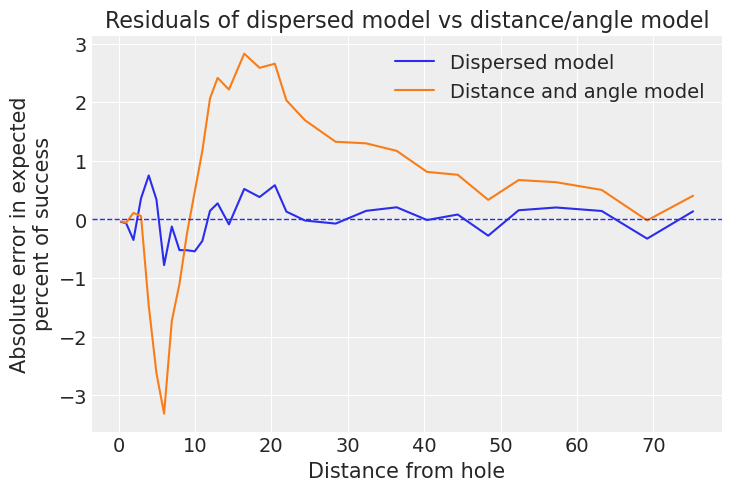

In [29]:
old_residuals = 100 * (new_golf_data.successes - ppc["success"].mean(axis=0)) / new_golf_data.tries

residuals = 100 * (
    new_golf_data.successes / new_golf_data.tries - disp_ppc["p_success"].mean(axis=0)
)

fig, ax = plt.subplots()

ax.plot(new_golf_data.distance, residuals, label="Dispersed model")
ax.plot(new_golf_data.distance, old_residuals, label="Distance and angle model")
ax.legend()
ax.axhline(y=0, linestyle="dashed", linewidth=1)
ax.set_xlabel("Distance from hole")
ax.set_ylabel("Absolute error in expected\npercent of success")
ax.set_title("Residuals of dispersed model vs distance/angle model");

## Beyond prediction

We want to use Bayesian analysis because we care about quantifying uncertainty in our parameters. We have a beautiful geometric model that not only gives us predictions, but gives us posterior distributions over our parameters. We can use this to back out how where our putts may end up, if not in the hole! 

First, we can try to visualize how 10,000 putts from a professional golfer might look. We:

1. Set the number of simulations to 10,000
2. Draw 10,000 random *joint* samples from `variance_of_shot` and `variance_of_distance`
3. For each of those, draw an angle and a distance from normal distributions
4. Plot the point, unless it would have gone in the hole

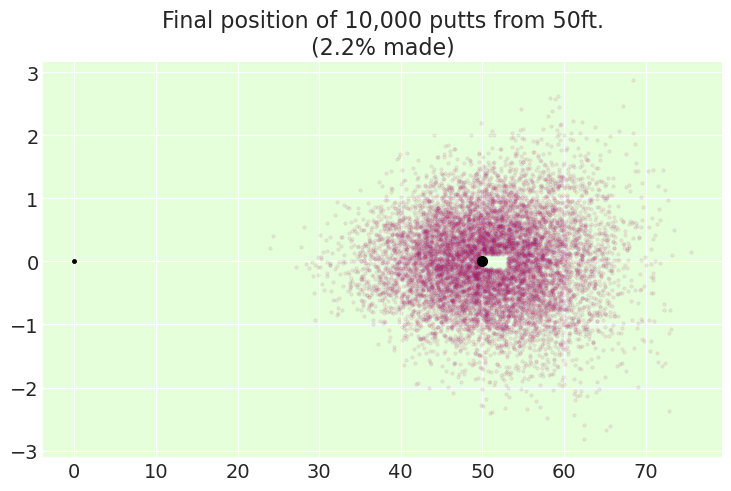

In [30]:
def simulate_from_distance(trace, distance_to_hole, trials=10_000):
    n_samples = len(trace.posterior["variance_of_shot"].data.flatten())

    idxs = np.random.randint(0, n_samples, trials)
    variance_of_shot = trace.posterior["variance_of_shot"].data.flatten()[idxs]
    variance_of_distance = trace.posterior["variance_of_distance"].data.flatten()[idxs]

    theta = np.random.normal(0, variance_of_shot)
    distance = np.random.normal(
        distance_to_hole + OVERSHOT, (distance_to_hole + OVERSHOT) * variance_of_distance
    )

    final_position = np.array([distance * np.cos(theta), distance * np.sin(theta)])

    made_it = np.abs(theta) < np.arcsin((CUP_RADIUS - BALL_RADIUS) / distance_to_hole)
    made_it = (
        made_it
        * (final_position[0] > distance_to_hole)
        * (final_position[0] < distance_to_hole + DISTANCE_TOLERANCE)
    )

    _, ax = plt.subplots()

    ax.plot(0, 0, "k.", lw=1, mfc="black", ms=250 / distance_to_hole)
    ax.plot(
        *final_position[:, ~made_it], ".", alpha=0.1, mfc="r", ms=250 / distance_to_hole, mew=0.5
    )
    ax.plot(distance_to_hole, 0, "ko", lw=1, mfc="black", ms=350 / distance_to_hole)

    ax.set_facecolor("#e6ffdb")
    ax.set_title(
        f"Final position of {trials:,d} putts from {distance_to_hole}ft.\n({100 * made_it.mean():.1f}% made)"
    )
    return ax


simulate_from_distance(distance_angle_trace, distance_to_hole=50);

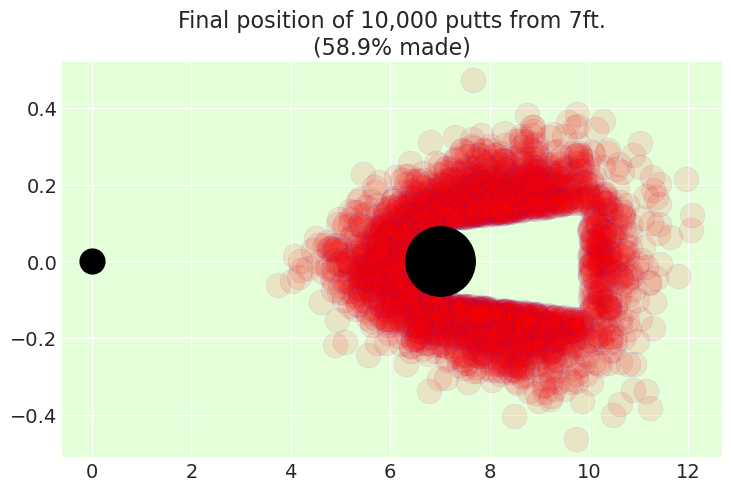

In [31]:
simulate_from_distance(distance_angle_trace, distance_to_hole=7);

We can then use this to work out how many putts a player may need to take from a given distance. This can influence strategic decisions like trying to reach the green in fewer shots, which may lead to a longer first putt, vs. a more conservative approach. We do this by simulating putts until they have all gone in.

Note that this is again something we might check experimentally. In particular, a highly unscientific search around the internet finds claims that professionals only 3-putt from 20-25ft around 3% of the time. Our model puts the chance of 3 or more putts from 22.5 feet at 2.8%, which seems suspiciously good.

In [32]:
def expected_num_putts(trace, distance_to_hole, trials=100_000):
    distance_to_hole = distance_to_hole * np.ones(trials)

    n_samples = trace.posterior["variance_of_shot"].data.flatten().shape[0]

    idxs = np.random.randint(0, n_samples, trials)
    variance_of_shot = trace.posterior["variance_of_shot"].data.flatten()[idxs]
    variance_of_distance = trace.posterior["variance_of_distance"].data.flatten()[idxs]
    n_shots = []
    while distance_to_hole.size > 0:
        theta = np.random.normal(0, variance_of_shot)
        distance = np.random.normal(
            distance_to_hole + OVERSHOT, (distance_to_hole + OVERSHOT) * variance_of_distance
        )

        final_position = np.array([distance * np.cos(theta), distance * np.sin(theta)])

        made_it = np.abs(theta) < np.arcsin((CUP_RADIUS - BALL_RADIUS) / distance_to_hole)
        made_it = (
            made_it
            * (final_position[0] > distance_to_hole)
            * (final_position[0] < distance_to_hole + DISTANCE_TOLERANCE)
        )

        distance_to_hole = np.sqrt(
            (final_position[0] - distance_to_hole) ** 2 + final_position[1] ** 2
        )[~made_it].copy()
        variance_of_shot = variance_of_shot[~made_it]
        variance_of_distance = variance_of_distance[~made_it]
        n_shots.append(made_it.sum())
    return np.array(n_shots) / trials

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in arcsin
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in less


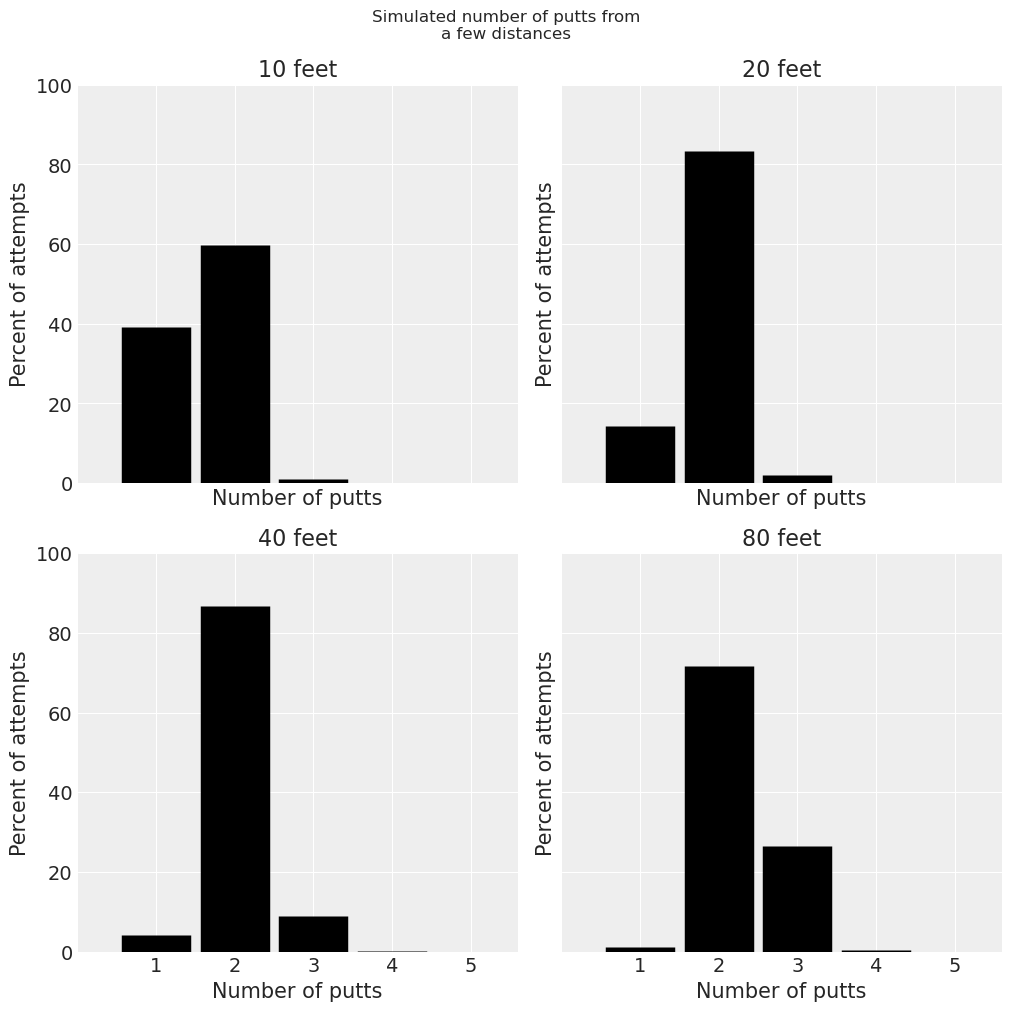

In [33]:
distances = (10, 20, 40, 80)
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10, 10))

for distance, ax in zip(distances, axes.ravel()):
    made = 100 * expected_num_putts(disp_distance_angle_trace, distance)
    x = np.arange(1, 1 + len(made), dtype=int)
    ax.vlines(np.arange(1, 1 + len(made)), 0, made, linewidths=50)
    ax.set_title(f"{distance} feet")
    ax.set_ylabel("Percent of attempts")
    ax.set_xlabel("Number of putts")
ax.set_xticks(x)
ax.set_ylim(0, 100)
ax.set_xlim(0, 5.6)
fig.suptitle("Simulated number of putts from\na few distances");

In [35]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Feb 23 2021

Python implementation: CPython
Python version       : 3.7.6
IPython version      : 7.13.0

pymc3     : 3.11.1
numpy     : 1.18.5
matplotlib: 3.2.1
pandas    : 1.1.5
scipy     : 1.4.1
arviz     : 0.11.2
theano    : 1.1.2

Watermark: 2.2.0

